## Lending Club Predictive Credit Models

**Intro**: Lending Club is an online Peer-to-Peer lender connecting borrowers and investors. They provide public data on the performance of their loans over time to provide transparency to the users of their online market place and curious data scientists. We can use this data to build our own credit model for the purpose of underwriting loans.

**Objective**: Create a model to predict the probability of credit default on Lending Club loans originated between 2007-2011. These are a mix of prime and subprime loans designated by the Lending Club "grade" (A, B, F, G). Your objective is to create a model and increase the benchmark results. You are encouraged to play around with different types of feature engineering, modeling techniques, and validation framesworks toward the aim of maximizing loan performance on a test set. I  will also use the resulting model on a hidden test set which is not included.

**Included Files**:
- lending-club-split.ipdb
- lending-club-environment.yml (This file contains an exported anaconda-virtualenv environment. This may be useful to set up your environment.)
- LoanStats3a-split-train.csv
- LoanStats3a-split-test.csv

**Notes**: 
Below I've started you off with some setup for the problem.
- Some imports
- A mechamnism for loading the data
- A benchmark result

*Please do not share this document within anyone outside of our organization.*

Once, completed. Save the jupyter notebook and return it to us.

In [1]:
import os
from os.path import normpath, join
import csv
import random
import math

import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm

from sklearn.metrics import roc_curve, auc

## Load data from csv
** Load the data from the provided CSV. **  Assume csv is in the same directory as this Jupyter notebook.

In [2]:
CURRENT_DIRECTORY = os.getcwd()
TRAIN_CSV_NAME = "LoanStats3a-split-train.csv"
TEST_CSV_NAME = "LoanStats3a-split-test.csv"
train_filepath = normpath(join(CURRENT_DIRECTORY, TRAIN_CSV_NAME))
test_filepath = normpath(join(CURRENT_DIRECTORY, TEST_CSV_NAME))

print "train_filepath: %s" % train_filepath
print "test_filepath: %s" % test_filepath

with open(train_filepath, "rb") as f:
    reader = csv.reader(f, delimiter=",")
    headers = reader.next()
    index = { h: i for i, h in enumerate(headers) }
    train_rows = [ r for r in reader ]
    
with open(test_filepath, "rb") as f:
    reader = csv.reader(f, delimiter=",")
    headers = reader.next()
    test_rows = [ r for r in reader ]

train_filepath: /Users/MaxTan/GitHub/Private_Projects/lending-club-problem/LoanStats3a-split-train.csv
test_filepath: /Users/MaxTan/GitHub/Private_Projects/lending-club-problem/LoanStats3a-split-test.csv


## Performance Metric

We use AUC (Area-under-the-curve) as an optimization metric. This is a popular metric within credit modeling.

In [3]:
def calculate_auc(y, y_pred):
    # y: an array of labels marking the actualy result as default (1) or non-default (0) 
    # y_pred: a probability that a row has defaulted
    # fpr: false-positive rate
    # tpr: true-positive rate
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score

## Setup default (y) variable

In [4]:
def is_default(loan_status):
    if loan_status.strip() in {"Charged Off", "Default"}:
        return 1.0
    elif loan_status.strip() == "Fully Paid":
        return 0.0
    raise Exception("Invalid status: %s" % loan_status)

y_train = np.array([ is_default(row[index["loan_status"]]) for row in train_rows ])
y_test = np.array([ is_default(row[index["loan_status"]]) for row in test_rows ])

print "train_total: %s" % len(y_train)
print "test_total: %s" % len(y_test)

train_total: 15598
test_total: 2198


## Random Guessing Example
random guessing should produce an AUC score of ~0.5

In [5]:
y_pred = [ random.choice([0.0, 1.0]) for _ in range(len(y_train)) ]
auc_score = calculate_auc(y_train, y_pred)
print "random-guess AUC: %s" % auc_score

random-guess AUC: 0.496529054791


## Benchmark Model

In [6]:
# Set up a variable
annual_inc_train = np.array([ math.log(float(row[index["annual_inc"]])) for row in train_rows ])
annual_inc_test = np.array([ math.log(float(row[index["annual_inc"]])) for row in test_rows ])

# Fit a model
logit = sm.Logit(y_train, annual_inc_train)
model = logit.fit()

# Annual income results
model = logit.fit()
y_pred = model.predict(annual_inc_test)
auc_score = calculate_auc(y_test, y_pred)
print "annual_inc-model AUC: %s" % auc_score

Optimization terminated successfully.
         Current function value: 0.339197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339197
         Iterations 6
annual_inc-model AUC: 0.547115684308


# Build your own models!
Feel free to make use of anything in the Python universe to help out. Recommended: making use of sklearn and pandas.

Also, free to refer to online resources related to credit modeling or the lending club data set without copying code.

## Tian's awesome model! :)

#### import required packages:

In [7]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
import statsmodels.api as sm
import time
from math import log
from os.path import normpath, join
from datetime import datetime
from copy import copy, deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline
pd.options.display.max_columns = 100
date_now =datetime.now()

In [11]:
def is_default(loan_status):
    """
    set default variable y function
    """
    if loan_status.strip() in {"Charged Off", "Default"}:
        return 1.0
    elif loan_status.strip() == "Fully Paid":
        return 0.0
    raise Exception("Invalid status: %s" % loan_status)
    
    
def calculate_auc(y, y_pred):
    """
    calculating AUC function
    """
    # y: an array of labels marking the actualy result as default (1) or non-default (0) 
    # y_pred: a probability that a row has defaulted
    # fpr: false-positive rate
    # tpr: true-positive rate
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score


def feature_engieering(tempdf,temp_y):
    """
    feature engineering function:
    
    input: 
    tempdf is original training dataframe or test dataframe
    temp_y is original training labels or test labels
    
    output: 
    return a new dataframe with selected features and proper transformations
    """
    #In the first place, after data exploration, I decided to remove the following variables,
    #since they don't have too much important information according to their distributions.
    del_feat = ["id","member_id","emp_title","loan_status","pymnt_plan","url",'desc','title',
                "initial_list_status","out_prncp","out_prncp_inv","next_pymnt_d","policy_code","random",
                "zip_code"]
    #But if I have time, I will use some NLP techiniques to extract important information from variables like "desc",
    #which might be helpful for the classification;
    
    tempdf = tempdf[[col for col in tempdf.columns if col not in del_feat]]
    
    #step 1: change term from string to int: 
    #The Number of payments on the loan. Values are in months and can be either 36 or 60.
    tempdf.ix[:,'term'] = map(lambda x: int(x.split()[0]),tempdf.term)

    #step 2: change issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d from string to timestamp:
    #issue_d: "Dec-2011"
    tempdf.ix[:,'issue_d']= map(lambda x:(date_now-datetime.strptime(x,"%b-%Y")).days/30, tempdf.issue_d)

    #earliest_cr_line: "Aug-1993"
    #The date the borrower's earliest reported credit line was opened
    tempdf.ix[:,'earliest_cr_line']= map(lambda x:(date_now-datetime.strptime(x,"%b-%Y")).days/30, tempdf.earliest_cr_line)

    #last_pymnt_d: "May-2013"
    tempdf.ix[:,'last_pymnt_d'] = tempdf['last_pymnt_d'].fillna('Jan-2007')
    tempdf.ix[:,'last_pymnt_d']= map(lambda x:(date_now-datetime.strptime(x,"%b-%Y")).days/30, tempdf.last_pymnt_d)

    #last_credit_pull_d: "May-2014"
    #The date LC pulled credit for this loan
    tempdf.ix[:,'last_credit_pull_d'] =tempdf['last_credit_pull_d'].fillna('Jan-2007')
    tempdf.ix[:,'last_credit_pull_d']= map(lambda x:(date_now-datetime.strptime(x,"%b-%Y")).days/30, tempdf.last_credit_pull_d)

    #step 3: change revol_util from string and NaN to int:
    #Only 6 NaN found in the training set, so we replace them with 0% or median:
    #Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
    tempdf.ix[:,'revol_util'] = tempdf['revol_util'].fillna('0%')
    tempdf.ix[:,'revol_util'] = map(lambda x:float(str(x)[:-1])/100,tempdf.revol_util)

    #step 4: change mths_since_last_delinq and mths_since_last_record from numerics(with NA) to no NA by using 999(large value).
    #The Number of months since the borrower's last delinquency.
    #So I decided to fill Na with very large values.
    tempdf.ix[:,'mths_since_last_delinq']= tempdf['mths_since_last_delinq'].fillna(999)
    #The Number of months since the last public record.
    tempdf.ix[:,'mths_since_last_record']= tempdf['mths_since_last_record'].fillna(999)

    #step 5: change emp_length from categorical to binary variable indicating if emp_length is more than a decade:
    #Employment length in months. Possible values are whole numbers from 0 and higher. Null indicates not employed.
    tempdf.ix[:,'emp_length']= map(lambda x: 10 if '10' in x else 0,tempdf.emp_length)

    #step 6: log or box-cox tranformation:
    
    #take log transformation towards certain variables based on their distribution plots:
    #annual_inc:The annual income provided by the borrower during registration.
    #revol_bal:Total credit revolving balance.
    log_feat = ["annual_inc",'revol_bal']
    for col in log_feat:
        tempdf.ix[:,col] = map(lambda x: log(x+1),tempdf.ix[:,col])
    
    #step 7: standardization:
    #find all continuous variables:
    num_feat = tempdf._get_numeric_data().columns
    #standardization if necessary: But it is proved that standardization didn't help
    #tempdf.ix[:,num_feat] = tempdf.ix[:,num_feat].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    tempdf.ix[:,['mths_since_last_delinq','mths_since_last_record']] = tempdf.ix[:,['mths_since_last_delinq','mths_since_last_record']].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    
    #Data visualization:
    """
    #check distribution of each distributions:
    
    for col in num_feat:
        plot = tempdf[[col]].iloc[:,:].plot(marker='*',title =col, color="g", linewidth=0.01)
        fig = plot.get_figure()
        fig.savefig(col+".png")
    """
    
    #raise exception if any missing value!!
    for col in tempdf.columns:
        if tempdf.ix[:,col].isnull().sum():
            raise Exception('Failed because there are '+str(tempdf.ix[:,col].isnull().sum())+' missing values in the feature: '+str(col))

    tempdf = pd.get_dummies(tempdf,dummy_na=True)
    tempdf.ix[:,'y'] = pd.Series(temp_y,index = tempdf.index)
    
    return tempdf

def cross_validation(X_train,feats):
    """
    cross validation function
    """
    #print X_train.shape,len(feats)
    kfolding = KFold(n = len(X_train),n_folds = 10, shuffle =True)
    cv_scores = []
    for train_idx, validation_idx in kfolding:
        
        train_X = X_train.ix[train_idx,feats]#all_feat]
        test_X = X_train.ix[validation_idx,feats]#all_feat]
        train_y = X_train.ix[train_idx,'y']
        test_y = X_train.ix[validation_idx,'y']
        
        #1. Logistic Regression:
        #model = LogisticRegression().fit(train_X,train_y)#->CV:0.82, TEST:0.82
        
        #2. Support Vector Machine:
        #model = svm.SVC(probability=True).fit(train_X,train_y)#too slow!!!
        #model = svm.LinearSVC().fit(train_X,train_y)
        
        #3. Random Forest(best):
        model = RandomForestClassifier(n_estimators=50).fit(train_X,train_y)#->CV:0.87,TEST:0.97 RECALL OF 1:0.64(50 trees)
        
        #4. GBDT:
        #model = GradientBoostingClassifier(n_estimators=50).fit(train_X,train_y)#->:CV:0.88,TEST:0.91 RECALL OF 1:0.15(50 trees)
        
        #pred_y = model.decision_function(test_X)#only when use SVC;
        pred_y = model.predict_proba(test_X)[:,1]

        auc_score = calculate_auc(test_y, pred_y)
        cv_scores.append(auc_score)
    return model,np.mean(cv_scores)

def test_function(model):
    """
    test function
    """
    y_res = model.predict(X_test.ix[:,imp_feat])
    y_pred = model.predict_proba(X_test.ix[:,imp_feat])[:,1]
    auc_score = calculate_auc(y_test, y_pred)

    #print out the metric report:
    print classification_report([int(i) for i in y_test], [int(i) for i in y_res])
    
    return auc_score

def plot_num_feat(clf):
    """"""
    #print len(clf.feature_importances_),len(all_feat)
    cv = []
    rg = range(1,50,2)
    for k in rg:
        imp_feat = [j for (i,j) in sorted(zip(clf.feature_importances_,all_feat),reverse=True)[:k]]
        #print len(imp_feat)
        _,mean_auc = cross_validation(X_train,imp_feat)
        cv.append(mean_auc)

    plt.plot(rg,cv)
    plt.xlabel('Number of Features', fontsize=18)
    plt.ylabel('Mean AUC', fontsize=16) 
    plt.title('Relationship between Number of Features and Mean AUC')
    plt.show()
    plt.savefig('Relationship between Number of Features and Mean AUC.jpg')
    plt.close()

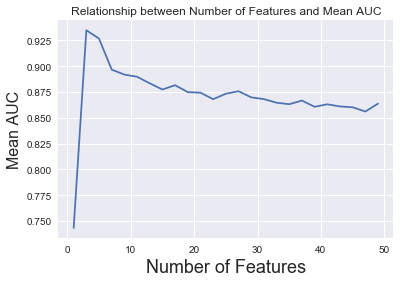

The mean AUC score of cross validation on training data is:
0.922447829075
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      1957
          1       0.97      0.77      0.86       241

avg / total       0.97      0.97      0.97      2198

The AUC score of test data is:
0.984207133876
--- 258.171395063 seconds ---


In [12]:
# main function:
start_time  = time.time()
if __name__ == '__main__':
    
    CURRENT_DIRECTORY = os.getcwd()
    TRAIN_CSV_NAME = "LoanStats3a-split-train.csv"
    TEST_CSV_NAME = "LoanStats3a-split-test.csv" #Please change the name to HIDDEN_CSV_NAME here :)

    train_filepath = normpath(join(CURRENT_DIRECTORY, TRAIN_CSV_NAME))
    test_filepath = normpath(join(CURRENT_DIRECTORY, TEST_CSV_NAME))
    
    #read in data from csv files based on previous path
    traindf = pd.read_csv(train_filepath)
    testdf = pd.read_csv(test_filepath)
    
    #run is_default function to create new response variable y:
    y_train = np.array([ is_default(row) for row in traindf.loan_status ])
    y_test = np.array([ is_default(row) for row in testdf.loan_status ])
    
    #run feature enginering to obtain new data frames:
    X_train = feature_engieering(traindf,y_train)
    X_test = feature_engieering(testdf,y_test)

    #obtain the common features for both training and test datasets:
    all_feat = list(set(X_train.columns).intersection(set(X_test.columns)).difference({'y'}))
    
    #feature selection:
    #method 1: choose feature by random forest importance;
    clf = RandomForestClassifier(n_estimators=10).fit(X_train.ix[:,all_feat],y_train)
    
    
    #decide how many important features should we use:
    plot_num_feat(clf)
    
    #method 2: chi square test to select features: (next step!!)
    #print SelectKBest(chi2, k=20).fit_transform(X_train, y_train).columns
    
    #according to the plot, the number of features can be decided:
    imp_feat = [j for (i,j) in sorted(zip(clf.feature_importances_,all_feat),reverse=True)[:5]]
    

    #cross_validation function:
    model,mean_auc = cross_validation(X_train,imp_feat)
    print 'The mean AUC score of cross validation on training data is:\n',str(mean_auc)

    #run test_function on test or hidden test set:
    test_auc = test_function(model)
    print 'The AUC score of test data is:\n',str(test_auc)

print("--- %s seconds ---" % (time.time() - start_time))

In [10]:
imp_feat[:20]

['last_credit_pull_d', 'last_pymnt_d', 'revol_util', 'issue_d', 'dti']

### Data Exploration to Play Around:

In [71]:
traindf.shape,testdf.shape

((15598, 36), (2198, 36))

#### check missing values:

In [72]:
labels = []
values = []
for col in traindf.columns:
    if traindf[col].isnull().sum():
        labels.append(col)
        values.append(traindf[col].isnull().sum())
        if values[-1]: print(col, values[-1])

('emp_title', 1073)
('desc', 5159)
('title', 4)
('mths_since_last_delinq', 11266)
('mths_since_last_record', 14772)
('revol_util', 7)
('last_pymnt_d', 18)
('next_pymnt_d', 15597)
('last_credit_pull_d', 2)


In [15]:
mis_feat = labels

In [21]:
#print cat_feat
#print num_feat
print mis_feat
print del_feat
#print all_feat

['emp_title', 'desc', 'title', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
['id', 'member_id', 'emp_title', 'loan_status', 'pymnt_plan', 'url', 'out_prncp', 'out_prncp_inv', 'initial_list_status', 'next_pymnt_d', 'policy_code', 'random', 'desc', 'title', 'zip_code', 'revol_util', 'mths_since_last_delinq', 'mths_since_last_record']


In [13]:
#test data set:
labels = []
values = []
for col in testdf.columns:
    labels.append(col)
    values.append(testdf[col].isnull().sum())
    if values[-1]:
        print(col, values[-1])

('emp_title', 144)
('desc', 792)
('title', 2)
('mths_since_last_delinq', 1564)
('mths_since_last_record', 2074)
('revol_util', 1)
('last_pymnt_d', 1)
('next_pymnt_d', 2198)


#### check different values for each feature:

In [14]:
tempdf = traindf
for col in tempdf:
    print col,len(set(tempdf[col])),"***",

id 15598 *** member_id 15598 *** term 2 *** emp_title 12236 *** emp_length 12 *** home_ownership 5 *** annual_inc 2611 *** verification_status 3 *** issue_d 54 *** loan_status 3 *** pymnt_plan 1 *** url 15598 *** desc 10351 *** purpose 14 *** title 8627 *** zip_code 769 *** addr_state 50 *** dti 2709 *** delinq_2yrs 8 *** earliest_cr_line 492 *** inq_last_6mths 9 *** mths_since_last_delinq 11354 *** mths_since_last_record 14860 *** open_acc 38 *** pub_rec 5 *** revol_bal 11494 *** revol_util 1021 *** total_acc 71 *** initial_list_status 1 *** out_prncp 2 *** out_prncp_inv 2 *** last_pymnt_d 93 *** next_pymnt_d 2 *** last_credit_pull_d 95 *** policy_code 1 *** random 7 ***


In [15]:
tempdf = testdf
for col in tempdf:
    print col,len(set(tempdf[col])),"***",

id 2198 *** member_id 2198 *** term 2 *** emp_title 1951 *** emp_length 12 *** home_ownership 4 *** annual_inc 626 *** verification_status 3 *** issue_d 53 *** loan_status 2 *** pymnt_plan 1 *** url 2198 *** desc 1402 *** purpose 14 *** title 1489 *** zip_code 537 *** addr_state 45 *** dti 1467 *** delinq_2yrs 7 *** earliest_cr_line 368 *** inq_last_6mths 8 *** mths_since_last_delinq 1648 *** mths_since_last_record 2122 *** open_acc 28 *** pub_rec 3 *** revol_bal 2045 *** revol_util 855 *** total_acc 62 *** initial_list_status 1 *** out_prncp 1 *** out_prncp_inv 1 *** last_pymnt_d 86 *** next_pymnt_d 2198 *** last_credit_pull_d 80 *** policy_code 1 *** random 1 ***


### Feature Count and Category Exploration:

In [34]:
len(set(traindf.id.values))

15598

In [33]:
len(set(traindf.member_id.values))

15598

In [35]:
len(set(traindf.term))

2

In [43]:
print len(set(traindf.emp_title))
dc1 = collections.Counter(traindf.emp_title)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

12236
[(nan, 1073), ('US Army', 42), ('Bank of America', 41), ('IBM', 26), ('AT&T', 20), ('UPS', 20), ('Lockheed Martin', 20), ('Wells Fargo', 19), ('US Air Force', 18), ('State of California', 17)]


In [47]:
print len(set(traindf.emp_length))
dc1 = collections.Counter(traindf.emp_length)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:20]]

12
[('10+ years', 3466), ('< 1 year', 1743), ('2 years', 1709), ('3 years', 1630), ('5 years', 1320), ('4 years', 1312), ('1 year', 1270), ('6 years', 879), ('7 years', 700), ('8 years', 584), ('9 years', 497), ('n/a', 488)]


In [48]:
print len(set(traindf.home_ownership))
dc1 = collections.Counter(traindf.home_ownership)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

5
[('MORTGAGE', 7211), ('RENT', 7096), ('OWN', 1249), ('OTHER', 40), ('NONE', 2)]


In [50]:
print len(set(traindf.verification_status))
dc1 = collections.Counter(traindf.verification_status)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

3
[('not verified', 7339), ('VERIFIED - income', 4391), ('VERIFIED - income source', 3868)]


In [163]:
print len(set(traindf.issue_d))
dc1 = collections.Counter(traindf.issue_d)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:50]]

54
[('Nov-2011', 923), ('Oct-2011', 898), ('Sep-2011', 888), ('Dec-2011', 808), ('Aug-2011', 776), ('Jul-2011', 738), ('Jun-2011', 730), ('Apr-2011', 598), ('May-2011', 584), ('Jan-2011', 568), ('Feb-2011', 557), ('Dec-2010', 518), ('Mar-2011', 513), ('Nov-2010', 461), ('Jul-2010', 437), ('Oct-2010', 413), ('Sep-2010', 412), ('Aug-2010', 410), ('Jun-2010', 400), ('May-2010', 365), ('Apr-2010', 325), ('Mar-2010', 308), ('Dec-2009', 265), ('Jan-2010', 238), ('Feb-2010', 237), ('Nov-2009', 227), ('Oct-2009', 225), ('Sep-2009', 188), ('Aug-2009', 172), ('Jun-2009', 157), ('Jul-2009', 150), ('May-2009', 139), ('Apr-2009', 95), ('Jan-2009', 85), ('Mar-2008', 77), ('Nov-2008', 77), ('Dec-2008', 73), ('Mar-2009', 72), ('Feb-2009', 70), ('Feb-2008', 63), ('Jan-2008', 60), ('Apr-2008', 54), ('Oct-2008', 39), ('Jul-2008', 33), ('Jun-2008', 25), ('Aug-2008', 24), ('May-2008', 24), ('Dec-2007', 23), ('Aug-2007', 17), ('Nov-2007', 15)]


In [55]:
print len(set(traindf.loan_status))
dc1 = collections.Counter(traindf.loan_status)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

3
[('Fully Paid', 13923), ('Charged Off', 1674), ('Default', 1)]


In [57]:
print len(set(traindf.pymnt_plan))
#pymnt plan and url are discarded?

1


In [59]:
print len(set(traindf.desc))
dc1 = collections.Counter(traindf.desc)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

10351
[(nan, 5159), (' ', 82), ('Camping Membership', 4), ('Debt consolidation loan', 2), ('credit card debt consolidation', 2), ('Personal loan', 2), ('Consolidate', 2), ('Debt consolidation', 2), ("Dear Lending Club lenders,   This is the 1st loan that I plan to take out to instill confidence in my ability to pay the loan, as well as any future loans that I may ask for in the future. Further, I may look to invest on LC as part of my portfolio building plan.   My current income is $98,000 a year as a senior project manager at a glass building plant in PA, with an annual bonus of $15k. I don't really need this loan. I will most likely pay it off within 2 months to see how LC works. Once I gain familiarity with the structure of P2P lending/borrowing, I will then consider LC as a viable option as an investment/borrowing tool.   I have excellent credit rating of 780, a DTI of less than 20%, and a history of personal credit that is well above the average American starting from 1993 on my E

In [62]:
print len(set(traindf.purpose))
dc1 = collections.Counter(traindf.purpose)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:20]]

14
[('debt_consolidation', 6827), ('credit_card', 2158), ('other', 1605), ('home_improvement', 1266), ('major_purchase', 991), ('car', 718), ('small_business', 644), ('wedding', 372), ('medical', 289), ('moving', 251), ('vacation', 163), ('house', 146), ('educational', 122), ('renewable_energy', 46)]


In [65]:
print len(set(traindf.title))

8627


In [64]:
print len(set(traindf.zip_code))
dc1 = collections.Counter(traindf.zip_code)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

769
[('100xx', 228), ('112xx', 206), ('945xx', 200), ('606xx', 194), ('070xx', 173), ('300xx', 167), ('900xx', 166), ('021xx', 159), ('941xx', 147), ('921xx', 145)]


In [67]:
print len(set(traindf.addr_state))
dc1 = collections.Counter(traindf.addr_state)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

50
[('CA', 2789), ('NY', 1486), ('FL', 1195), ('TX', 1072), ('NJ', 660), ('IL', 611), ('PA', 585), ('GA', 559), ('VA', 544), ('MA', 544)]


In [68]:
print len(set(traindf.dti))

2709


In [75]:
print len(set(traindf.delinq_2yrs))
dc1 = collections.Counter(traindf.delinq_2yrs)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

8
[(0, 14408), (1, 960), (2, 163), (3, 50), (4, 13), (5, 2), (6, 1), (8, 1)]


In [76]:
print len(set(traindf.earliest_cr_line))

492


In [78]:
print len(set(traindf.inq_last_6mths))
dc1 = collections.Counter(traindf.inq_last_6mths)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

9
[(0, 8478), (1, 3925), (2, 1964), (3, 979), (4, 159), (5, 66), (6, 16), (7, 9), (8, 2)]


In [165]:
#Important!!!
#mths_since_last_delinq
print len(set(traindf.mths_since_last_delinq))
dc1 = collections.Counter(traindf.mths_since_last_delinq)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:100]]

11354
[(0.0, 185), (24.0, 78), (20.0, 76), (45.0, 75), (30.0, 74), (18.0, 72), (31.0, 72), (19.0, 71), (32.0, 70), (36.0, 70), (39.0, 70), (12.0, 69), (22.0, 69), (23.0, 69), (16.0, 68), (25.0, 68), (29.0, 67), (35.0, 67), (47.0, 67), (26.0, 66), (27.0, 66), (38.0, 66), (37.0, 65), (17.0, 63), (34.0, 63), (43.0, 61), (46.0, 61), (15.0, 60), (21.0, 60), (48.0, 59), (73.0, 59), (28.0, 57), (33.0, 57), (40.0, 57), (44.0, 57), (42.0, 56), (14.0, 54), (41.0, 53), (11.0, 52), (6.0, 52), (13.0, 50), (75.0, 50), (9.0, 49), (53.0, 49), (56.0, 49), (52.0, 47), (71.0, 47), (49.0, 46), (67.0, 45), (68.0, 45), (69.0, 45), (59.0, 43), (8.0, 42), (58.0, 42), (79.0, 41), (81.0, 41), (10.0, 40), (55.0, 40), (63.0, 40), (66.0, 40), (3.0, 39), (5.0, 39), (70.0, 39), (76.0, 39), (72.0, 38), (50.0, 37), (62.0, 37), (61.0, 36), (54.0, 34), (64.0, 34), (74.0, 34), (60.0, 33), (65.0, 33), (78.0, 33), (7.0, 33), (4.0, 31), (57.0, 30), (77.0, 29), (51.0, 27), (2.0, 26), (80.0, 26), (82.0, 22), (1.0, 6), (nan, 1

In [82]:
#Important!!!
#mths_since_last_record
print len(set(traindf.mths_since_last_record))
dc1 = collections.Counter(traindf.mths_since_last_record)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

14860
[(0.0, 234), (91.0, 21), (93.0, 20), (104.0, 19), (110.0, 19), (97.0, 18), (108.0, 17), (111.0, 17), (89.0, 16), (96.0, 16)]


In [84]:
print len(set(traindf.open_acc))
dc1 = collections.Counter(traindf.open_acc)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

38
[(6, 1714), (7, 1679), (8, 1587), (9, 1502), (10, 1304), (5, 1219), (11, 1101), (12, 938), (4, 824), (13, 755)]


In [86]:
print len(set(traindf.pub_rec))
dc1 = collections.Counter(traindf.pub_rec)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

5
[(0, 15006), (1, 580), (2, 10), (3, 1), (4, 1)]


In [88]:
print len(set(traindf.revol_bal))
dc1 = collections.Counter(traindf.revol_bal)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

11494
[(0, 396), (66, 8), (298, 8), (39, 7), (1, 6), (6, 6), (52, 6), (346, 6), (682, 6), (894, 6)]


In [192]:
print len(set(traindf.revol_util))
print set([type(i) for i in traindf.revol_util])

print [i for i in traindf.revol_util if type(i) == float]
dc1 = collections.Counter(traindf.revol_util)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:50]]

1021
set([<type 'str'>, <type 'float'>])
[nan, nan, nan, nan, nan, nan, nan]
[('0%', 430), ('0.1%', 35), ('36.5%', 33), ('0.2%', 32), ('1%', 32), ('16.5%', 31), ('32%', 31), ('21.5%', 31), ('23.8%', 30), ('33.3%', 30), ('23.7%', 29), ('31.2%', 29), ('33.7%', 29), ('40.7%', 29), ('22.1%', 29), ('54.6%', 28), ('26.7%', 28), ('2.3%', 28), ('0.7%', 28), ('62%', 28), ('35.3%', 28), ('0.5%', 28), ('37.4%', 28), ('7.2%', 28), ('0.3%', 27), ('17.9%', 27), ('27.2%', 27), ('21.1%', 27), ('67.6%', 27), ('7.6%', 26), ('54.9%', 26), ('41.6%', 26), ('14.8%', 26), ('36.1%', 26), ('1.8%', 26), ('8.8%', 26), ('14.9%', 26), ('18.2%', 25), ('8.6%', 25), ('8.9%', 25), ('41.9%', 25), ('12.4%', 25), ('46.6%', 25), ('25.7%', 25), ('31.1%', 25), ('29.3%', 25), ('48.7%', 25), ('47.5%', 25), ('31.9%', 25), ('16.7%', 25)]


In [92]:
print len(set(traindf.total_acc))
dc1 = collections.Counter(traindf.total_acc)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

71
[(20, 593), (15, 583), (18, 577), (17, 574), (21, 562), (13, 559), (14, 548), (16, 547), (24, 542), (22, 526)]


In [93]:
print len(set(traindf.initial_list_status))
#initial_list_status is discarded?

1


In [95]:
print len(set(traindf.out_prncp))
dc1 = collections.Counter(traindf.out_prncp)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]
#outlier?

2
[(0.0, 15597), (89.950000000000003, 1)]


Outlier?

In [97]:
print len(set(traindf.out_prncp_inv))
dc1 = collections.Counter(traindf.out_prncp_inv)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]
#outlier?

2
[(0.0, 15597), (89.950000000000003, 1)]


In [99]:
print len(set(traindf.last_pymnt_d))
dc1 = collections.Counter(traindf.last_pymnt_d)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

93
[('Mar-2013', 452), ('Dec-2014', 439), ('Aug-2014', 413), ('Feb-2013', 393), ('Jan-2014', 387), ('May-2013', 386), ('Oct-2014', 386), ('Jul-2014', 384), ('Apr-2013', 384), ('Mar-2014', 376)]


In [101]:
print len(set(traindf.next_pymnt_d))
dc1 = collections.Counter(traindf.next_pymnt_d)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]
#outlier?

2
[(nan, 15597), ('Oct-2015', 1)]


In [103]:
print len(set(traindf.last_credit_pull_d))
dc1 = collections.Counter(traindf.last_credit_pull_d)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]

95
[('Sep-2015', 3632), ('Feb-2013', 408), ('Dec-2014', 343), ('Aug-2014', 319), ('Oct-2014', 318), ('Jul-2015', 316), ('Jul-2014', 303), ('Nov-2014', 300), ('Jan-2014', 292), ('Mar-2014', 291)]


In [104]:
print len(set(traindf.policy_code))
#policy_code is discarded?

1


In [106]:
print len(set(traindf.random))
dc1 = collections.Counter(traindf.random)
print [(key,dc1[key]) for key in sorted(dc1, key=dc1.get,reverse=True)[:10]]
#cross-validation?

7
[(2, 2283), (5, 2237), (3, 2236), (1, 2219), (4, 2215), (6, 2208), (7, 2200)]
